# Calibration Constant Temperature Dependence (Experimental conditions)

------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

------------------------------------------------------------------

## <span style='color:deepskyblue'>Global Variables (Conditions) </span>

In [2]:
#========== Conditions ==========

# Wavelengths [µm]
λ1 = 1.064        # Fundamental - Pump Beam Wavelength
λ2 = 0.532        # Second Harmonic Wavelength

lambda_fund = λ1       # ω
lambda_SH = λ2        # 2ω

# Temperature range [K] (Experimetnal Conditions)
lower_T = 290 
upper_T = 380  
data_points =  abs(lower_T - upper_T) * 5 # 5 data points per degree K
print("Data points:", data_points)

# Temperature array [K]
T_K = np.linspace(lower_T, upper_T, data_points)

# Presure [mbar] - Constatnt
p_mbar = 1000.0 # Atmospheric pressure
p_Pa = p_mbar * 100  # Convert to Pa in SI (approximation)

#Reference Pressure and Temperature
T0_K=273.16


# Interaction length [m] - Lenght of electrodes
L_m = 0.09 #[m]


#Constants
epsilon_0 = 8.854187812e-12  # [s^4 A^2 / (m^3 kg)]
c = 299792458  # in m/s
#================================

# Enable plotting:
ploting = True
# ploting = False

# One gas plotting
# one_gas_only = True
one_gas_only = False

gas_to_plot = "N2"  # Options: "N2", "O2", "CO2", "CH4", "He", "Ne", "Ar", "Kr", "Xe"


Data points: 450


In [3]:
# Gas labels for plotting
GAS_LABELS = {
    "N2": r"N$_2$",
    "O2": r"O$_2^*$",
    "CO2": r"CO$_2^*$",
    "CH4": r"CH$_4^*$",
    "He": r"He",
    "Ne": r"Ne",
    "Ar": r"Ar",
    "Kr": r"Kr",
    "Xe": r"Xe",
    #"Air": r"Air"
}
# Gas colors for plotting
GAS_COLORS = {
    "N2": "blue",
    "O2": "green",
    "CO2": "red",
    "CH4": "orange",
    "He": "purple",
    "Ne": "cyan",
    "Ar": "magenta",
    "Kr": "brown",
    "Xe": "pink",
    #"Air": "gray"
}
GAS_COLORS_DARK = {
    "N2": "darkblue",
    "O2": "darkgreen",
    "CO2": "darkred",
    "CH4": "darkorange",
    "He": "indigo",
    "Ne": "darkcyan",
    "Ar": "darkmagenta",
    "Kr": "saddlebrown",
    "Xe": "deeppink",
    #"Air": "dimgray"
}

------------------------------------------------------------------

### Sellmeier Equation 

In [4]:
# ==============================
#   Refractive-index data
# ==============================

# Table from Borzsonyi et al. (2008), Table 2
# Sellmeier coefficients at p0=1000 mbar, T0=273 K (lambda in µm)
# Columns:      B1,         C1,         B2,         C2
SELLMEIER_COEFFS = {
    "N2":  (39209.95e-8, 1146.24e-6, 18806.48e-8, 13.476e-3),
    "He":  ( 4977.77e-8,   28.54e-6,  1856.94e-8,  7.760e-3),
    "Ne":  ( 9154.48e-8,  656.97e-6,  4018.63e-8,  5.728e-3),
    "Ar":  (20332.29e-8,  206.12e-6, 34458.31e-8,  8.066e-3),
    "Kr":  (26102.88e-8,    2.01e-6, 56946.82e-8, 10.043e-3),
    "Xe":  (103701.61e-8,  12.75e-6, 31228.61e-8,  0.561e-3),
    #"Air": (14926.44e-8,   19.36e-6, 41807.57e-8,  7.434e-3),
}

# Constant refractive indices for gases without Sellmeier model (from Polyanskiy 2024)
# Values at standard conditions, keyed by wavelength in µm
CONSTANT_REF_INDEX = {
    "O2": {
        0.532: 1.00025325,
        1.064: 1.00024844,
    },
    "CO2": {
        0.532: 1.00045089,
        1.064: 1.00044187,
    },
    "CH4": {
        0.532: 1.00044776,
        1.064: 1.00043159,  
    },
}

In [5]:
# All gases to be plotted
ALL_GASES = list(SELLMEIER_COEFFS.keys()) + list(CONSTANT_REF_INDEX.keys())

In [6]:
# ==============================
#   Refractive index function
# ==============================
def refractive_index(lambda_um, T_K, p_Pa=1e5, gas="N2", p0_Pa=1e5, T0_K=273.16):

    lambda_um = float(lambda_um)
    T_K = np.asarray(T_K, dtype=float)

    # Case 1: constant-n gases (O2, CO2, CH4) 
    if gas in CONSTANT_REF_INDEX:
        const_dict = CONSTANT_REF_INDEX[gas]

        # Choose the closest defined wavelength (0.532 or 1.064 µm)
        known_lams = np.array(list(const_dict.keys()))
        idx = np.argmin(np.abs(known_lams - lambda_um))
        lam_choice = known_lams[idx]
        n_const = const_dict[lam_choice]

        return np.full_like(T_K, n_const, dtype=float)

    # Case 2: Sellmeier gases    
    if gas not in SELLMEIER_COEFFS:
        raise ValueError(
            f"Unknown gas '{gas}'. Use one of: {list(SELLMEIER_COEFFS) + list(CONSTANT_REF_INDEX)} ")
    
    B1, C1, B2, C2 = SELLMEIER_COEFFS[gas]

    lam2 = lambda_um ** 2
    scale = (p_Pa / p0_Pa) * (T0_K / T_K)

    denom1 = lam2 - C1
    denom2 = lam2 - C2
    
    # Avoid division by zero if lambda^2 == Cj
    if np.any(denom1 == 0) or np.any(denom2 == 0):
        raise ValueError("Wavelength squared equals one of the Sellmeier coefficients Cj, causing division by zero.")

    bracket = (B1 * lam2 / denom1) + (B2 * lam2 / denom2)
    n2 = 1.0 + scale * bracket

    return np.sqrt(n2)

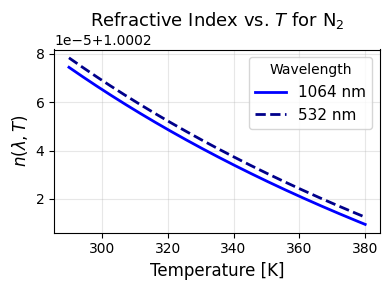

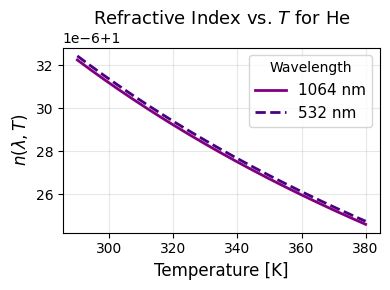

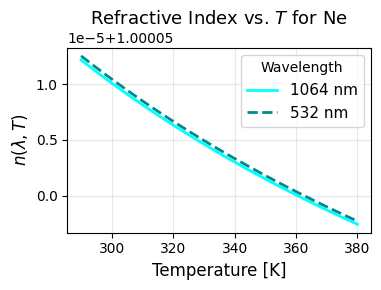

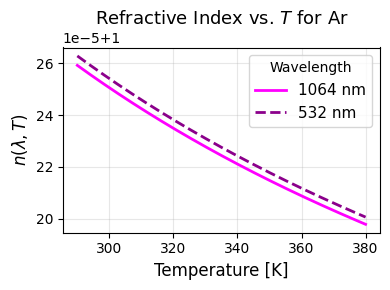

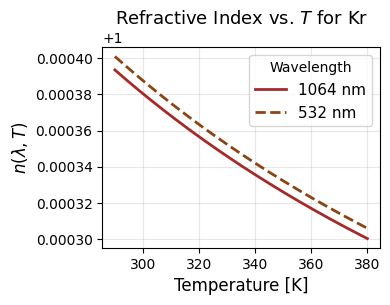

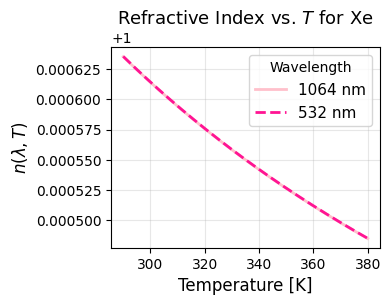

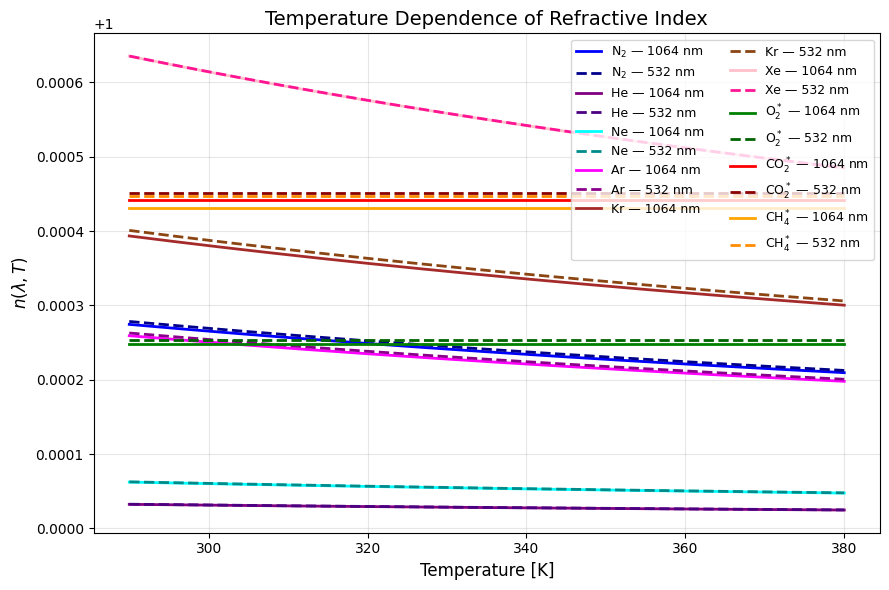

In [7]:
#==============================
# PLOTTING
#==============================
# Plotting refractive index vs.Temperature for all gases
if ploting:
    for gas in ALL_GASES:
        
        if one_gas_only:
            
            if gas != gas_to_plot: continue # Plot for a single gas only
        
        if list(CONSTANT_REF_INDEX.keys()).__contains__(gas):
            continue
        n_fund = refractive_index(lambda_fund, T_K, p_Pa=p_Pa, gas=gas)
        n_SH   = refractive_index(lambda_SH,   T_K, p_Pa=p_Pa, gas=gas)

        plt.figure(figsize=(4, 3))
        plt.plot(T_K, n_fund, label=f"{int(lambda_fund * 1000)} nm", lw=2, color=GAS_COLORS.get(gas, gas))
        plt.plot(T_K, n_SH,   label=f"{int(lambda_SH * 1000)} nm",  lw=2, ls='--', color=GAS_COLORS_DARK.get(gas, gas))

        plt.xlabel("Temperature [K]", fontsize=12)
        plt.ylabel(r"$n(\lambda,T)$", fontsize=12)
        plt.title(rf"Refractive Index vs. $T$ for {GAS_LABELS[gas]}", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.legend(title="Wavelength", fontsize=11)
        plt.tight_layout()
        plt.show()


plt.figure(figsize=(9, 6))

for gas in ALL_GASES:
    # if list(CONSTANT_REF_INDEX.keys()).__contains__(gas):
    #         continue

    # Fund. and SH wavelengths
    n_fund = refractive_index(lambda_fund, T_K, p_Pa=p_Pa, gas=gas)
    n_SH   = refractive_index(lambda_SH,   T_K, p_Pa=p_Pa, gas=gas)

    # Label (fallback if GAS_LABELS not defined)
    label = GAS_LABELS.get(gas, gas) if "GAS_LABELS" in globals() else gas

    # Plot fundamental (solid)
    plt.plot(T_K, n_fund, lw=2, label=rf"{label} — {int(lambda_fund*1000)} nm", color=GAS_COLORS.get(gas, gas))

    # Plot SH (dashed)
    plt.plot(T_K, n_SH, lw=2, ls="--", label=rf"{label} — {int(lambda_SH*1000)} nm", color=GAS_COLORS_DARK.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"$n(\lambda,T)$", fontsize=12)
plt.title("Temperature Dependence of Refractive Index", fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()        

------------------------------------------------------------------

### Wavevector Mismatch

In [8]:
# Δk in units of 1/µm (or 1/m if to_m=True)
def wavevector_mismatch(lambda_fund, lambda_SH, T_K, p_Pa=1e5, gas="N2", to_m=True):
    n_fund = refractive_index(lambda_fund, T_K, p_Pa=p_Pa, gas=gas)
    n_SH   = refractive_index(lambda_SH,   T_K, p_Pa=p_Pa, gas=gas)

    delta_k_um = (4 * np.pi / lambda_fund) * (n_SH - n_fund) # [rad/µm]

    if to_m:
        return delta_k_um * 1e6  # 1/µm → 1/m [rad/m]
    else:
        return delta_k_um # [rad/µm]

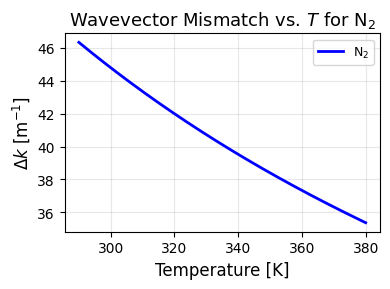

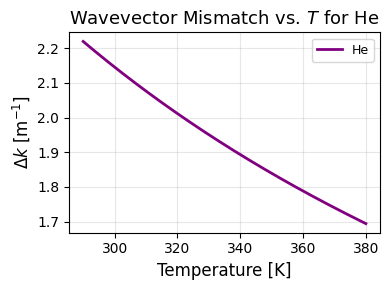

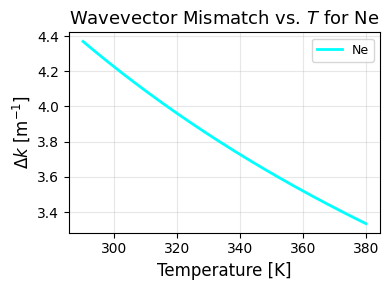

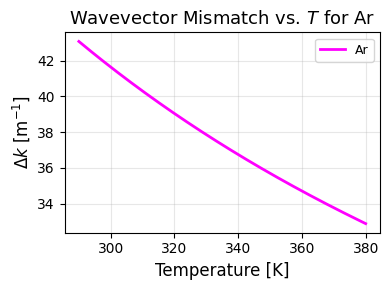

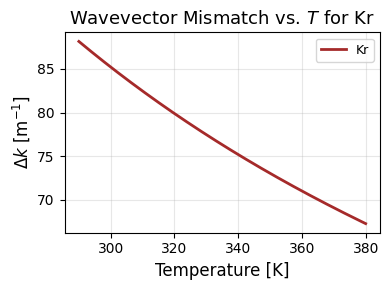

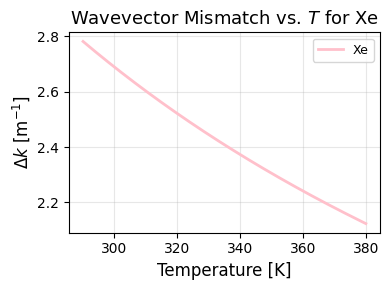

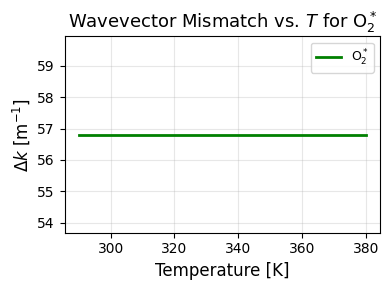

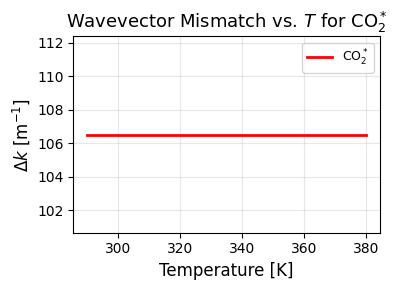

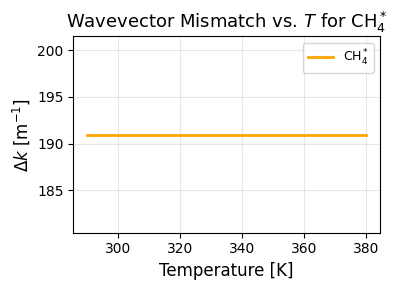

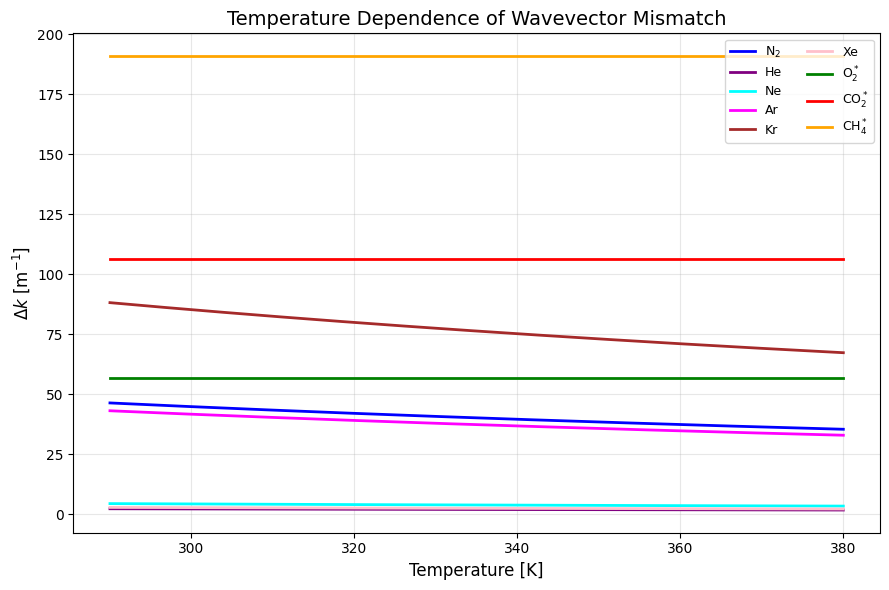

In [9]:
#==============================
# PLOTTING
#==============================
# Plotting Δk vs.Temperature for each gas
if ploting:
    for gas in ALL_GASES:    
        if one_gas_only:
            
            if gas != gas_to_plot: continue # Plot for a single gas only

        plt.figure(figsize=(4, 3))
        plt.plot(T_K, wavevector_mismatch(lambda_fund, lambda_SH, T_K, p_Pa=p_Pa, gas=gas), color=GAS_COLORS.get(gas, gas), lw=2, label=GAS_LABELS.get(gas, gas))

        plt.xlabel("Temperature [K]", fontsize=12)
        plt.ylabel(r"$\Delta k$ [m$^{-1}$]", fontsize=12)
        plt.title(rf"Wavevector Mismatch vs. $T$ for {GAS_LABELS[gas]}", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=9, ncol=2)
        plt.tight_layout()
        plt.show()

plt.figure(figsize=(9, 6))

# Plotting Δk vs.Temperature for all gases
for gas in ALL_GASES:
    
    delta_k = wavevector_mismatch(lambda_fund, lambda_SH, T_K, p_Pa=p_Pa, gas=gas)
    label = GAS_LABELS.get(gas, gas) if "GAS_LABELS" in globals() else gas
    plt.plot(T_K, delta_k, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"$\Delta k\ \mathrm{[m^{-1}]}$", fontsize=12)
plt.title("Temperature Dependence of Wavevector Mismatch", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

------------------------------------------------------------------

### Angular Frequency

In [10]:
# Angular frequency from wavelength
def angular_frequency(lambda_um):
    
    #ω (in rad/s) from wavelength lambda (in µm).
    
    c = 299792458  # in m/s
    lambda_m = lambda_um * 1e-6  # Convert µm to m
    omega = 2 * np.pi * c / lambda_m # in rad/s
    return omega

------------------------------------------------------------------

## Third-Order Susceptibility

###     - Molecular Number Denisty

In [11]:
# Molecular Number Density in molecules/m^3
def molecular_density(T_K, p_Pa=1e5):

    k_boltzmann = 1.380649e-23  # J/K
    
    return (p_Pa * 100) / (k_boltzmann * T_K) # molecules/m^3

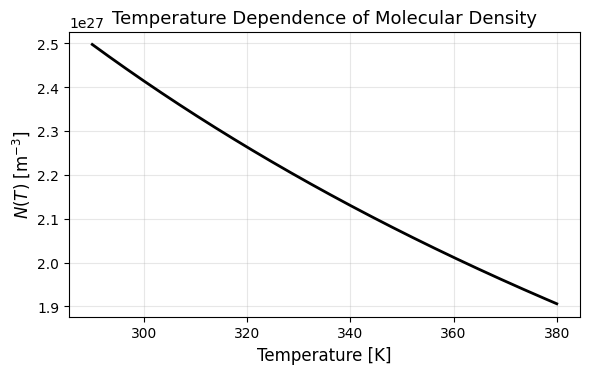

In [12]:
#==============================
# PLOTTING
#==============================

# Plotting Molecular Density vs.Temperature
N = molecular_density(T_K, p_Pa=1e5)  # in 1/m^3

plt.figure(figsize=(6,4))
plt.plot(T_K, N, color='black', lw=2)
plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"$N(T)$ [m$^{-3}$]", fontsize=12)
plt.title("Temperature Dependence of Molecular Density", fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### - Second Hyperpolarizability

In [13]:
#==============================
# Second hyperpolarizabilities Data
#==============================
#  Second hyperpolarizabilities from Table III Shelton (1990) for λ = 1.064 µm
#  Units in the paper: C^4 m^4 J^-3
GAMMA_SHELTON_1064 = {
    "He":   6.855e-63,
    "Ne":   6.816e-63,
    "Ar":   77.12e-63,
    "Kr":   176.65e-63,
    "Xe":   474.1e-63,
    "N2":   60.14e-63,
    "O2":   64.31e-63,
    "CO2":  77.33e-63,
    "CH4":  176.65e-63,
}

In [14]:
# Second hyperpolarizability in SI units
def gamma_SI(gas):
    # Return second hyperpolarizability γ in [C^4 m^4 J^-3] for the given gas in SI units [m^5 / V^2].
    # Conversion is done by division by ε0
    
    EPSILON_0 = 8.854187812e-12  # [s^4 A^2 / (m^3 kg)]

    if gas not in GAMMA_SHELTON_1064:
        raise ValueError(
            f"Unknown gas '{gas}' for γ. Available: {list(GAMMA_SHELTON_1064.keys())}"
        )
    gamma_raw = GAMMA_SHELTON_1064[gas]  # [C^4 m^4 J^-3]
    gamma_si = gamma_raw / EPSILON_0  # [m^5 V^-2]
    return gamma_si

#### - Dielectric Constant

In [15]:
#==============================
# Dielectric Data
#==============================
# Table from Harvey & Lemmon (2005), Table II (original units)
# Units:
    # a0, a1 → cm³/mol
    # b0, b1 → cm⁶/mol²
    # c0, c1 → cm^(3*(D+1))/mol^(D+1)
    # D → dimensionless
# Units: a0, a1 [cm^3/mol]; b0, b1 [cm^6/mol^2]; c0, c1 [cm^(3(D+1))/mol^(D+1)]
HARVEY_LEMMON_PARAMS = {
    "He":  {"a0": 0.517254, "a1": 0.0,      "b0": -0.203,  "b1": 0.039, #
            "c0": 7.47,     "c1": 0.0,      "D":  2.0},
    "Ne":  {"a0": 0.9969,   "a1": 0.0,      "b0": -0.109,  "b1": 0.0708,
            "c0": -2.88,    "c1": -1.0,     "D":  2.0},
    "Ar":  {"a0": 4.1414,   "a1": 0.0,      "b0": 1.597,   "b1": 0.262,
            "c0": -117.9,   "c1": 0.0,      "D":  2.1},
    "Kr":  {"a0": 6.273,    "a1": 0.0,      "b0": 6.485,   "b1": 13.48, #
            "c0": -82.51,   "c1": -170.4,   "D":  1.7},
    "Xe":  {"a0": 10.122,   "a1": 0.0,      "b0": 31.97,   "b1": 46.97,
            "c0": -948.4,   "c1": 0.0,      "D":  1.7},
    "N2":  {"a0": 4.3872,   "a1": 0.00226,  "b0": 2.206,   "b1": 1.135,
            "c0": -169.0,   "c1": -35.83,   "D":  2.1},
    "O2":  {"a0": 3.9578,   "a1": 0.0065,   "b0": 0.575,   "b1": 1.028,
            "c0": -8.96,    "c1": -5.15,    "D":  1.5},
    "CO2": {"a0": 7.3455,   "a1": 0.00335,  "b0": 83.93,   "b1": 145.1, #
            "c0": -578.8,   "c1": -1012.0,  "D":  1.55},
    "CH4": {"a0": 6.5443,   "a1": 0.0133,   "b0": 8.4578,  "b1": 3.7196,
            "c0": -352.97,  "c1": -100.65,  "D":  2.0},
}

In [16]:
#==============================
# Molar density
#==============================

# Molar density from molecular density and Avogadro's number
def molar_density(T_K, p_Pa=1e5):

    NA_mol = 6.02214076e23  # molecules/mol

    return molecular_density(T_K, p_Pa) / NA_mol # mol/m^3

In [17]:
#==============================
# Molar polarization over molar density P/ρ
#==============================
def PCM_over_rho(T_K, rho_mol_cm, gas, T0_K=273.16):

    pars = HARVEY_LEMMON_PARAMS[gas] 

    D  = pars["D"]

    a0, a1 = pars["a0"], pars["a1"]
    b0, b1 = pars["b0"], pars["b1"]
    c0, c1 = pars["c0"], pars["c1"]

    A_eps = a0 + a1 * (T_K / T0_K - 1.0)
    B_eps = b0 + b1 * (T0_K / T_K - 1.0)
    C_eps = c0 + c1 * (T0_K / T_K - 1.0)

    return A_eps + B_eps * rho_mol_cm + C_eps * rho_mol_cm**D

In [18]:
#==============================
# Relative permittivity ε(T,ρ)
#==============================
def epsilon_rel(T_K, p_Pa, gas):
    
    rho_mol_cm = molar_density(T_K, p_Pa) / 1e6 # mol/cm^3
    P_over_rho = PCM_over_rho(T_K, rho_mol_cm, gas=gas)
    
    P_CM = rho_mol_cm * P_over_rho  

    return (1.0 + 2.0 * P_CM) / (1.0 - P_CM)

### - Local Field Factors

In [19]:
#==============================
# Local field factors
#==============================
def f0_field(n, epsilon):
    return (epsilon * (n**2 + 2) ) / ( n**2 + 2*epsilon )

def f_field(n):
    return (n**2 + 2) /3

In [20]:
# Compute temperature dependent local field factors: L0(T), L_ω(T), L_2ω(T) for a given gas.
def local_field_factors(T_K, lambda_fund, lambda_SH, p_Pa=1e5, gas="N2",):

    # Refractive indices at ω and 2ω
    n_omega = refractive_index(lambda_fund, T_K, p_Pa=p_Pa, gas=gas)
    n_2omega = refractive_index(lambda_SH, T_K, p_Pa=p_Pa, gas=gas)

    # Static dielectric constant (relative permittivity)
    eps = epsilon_rel(T_K, p_Pa=p_Pa, gas=gas)

    # Local field factors
    L0 = f0_field(n_omega, eps)
    L_omega_squared = f_field(n_omega)**2
    L_2omega = f_field(n_2omega)

    return L0, L_omega_squared, L_2omega

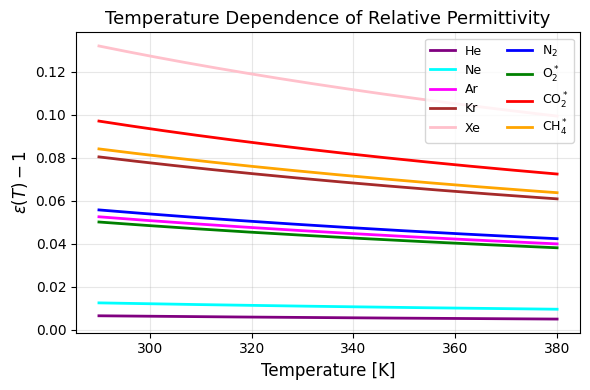

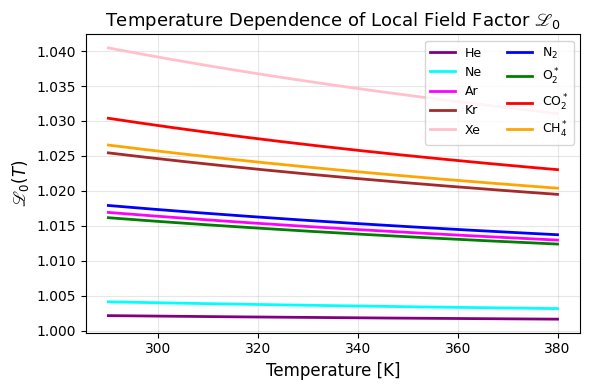

In [21]:
#==============================
# PLOTTING
#==============================

# Plot epsilon(T) - 1 for visual clarity 
plt.figure(figsize=(6, 4))
for gas in HARVEY_LEMMON_PARAMS.keys():
    if one_gas_only:
        
        if gas != gas_to_plot: continue # Plot for a single gas only

    eps_T = epsilon_rel(T_K, p_Pa=p_Pa, gas=gas)
    label = GAS_LABELS.get(gas, gas)
    plt.plot(T_K, eps_T - 1.0, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"$\epsilon(T) - 1$", fontsize=12)
plt.title(r"Temperature Dependence of Relative Permittivity", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

# Plot L0(T) for each gas at λ = 1064 nm 
plt.figure(figsize=(6, 4))
for gas in HARVEY_LEMMON_PARAMS.keys():
    
    if one_gas_only:
        
        if gas != gas_to_plot: continue # Plot for a single gas only

    L0, _, _ = local_field_factors(T_K, p_Pa=p_Pa, gas=gas,
                                    lambda_fund=lambda_fund,
                                    lambda_SH=lambda_SH)
    label = GAS_LABELS.get(gas, gas)
    plt.plot(T_K, L0, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"$\mathscr{L}_0(T)$", fontsize=12)
plt.title(r"Temperature Dependence of Local Field Factor $\mathscr{L}_0$", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

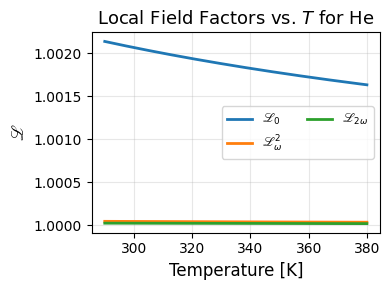

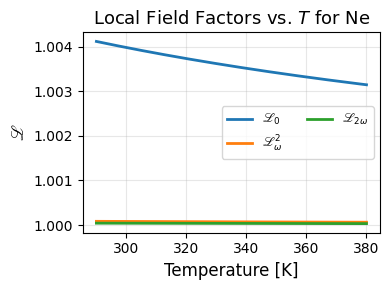

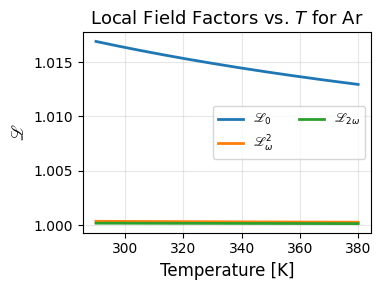

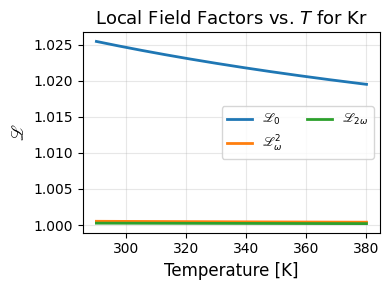

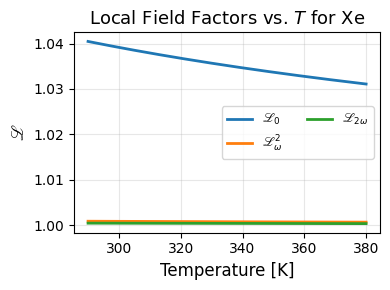

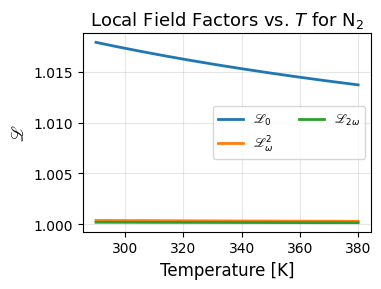

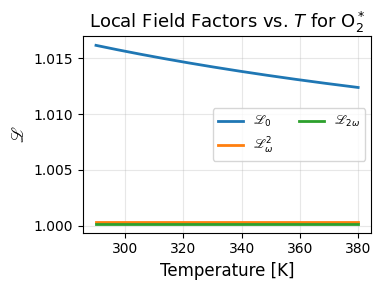

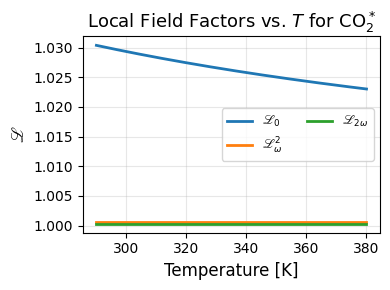

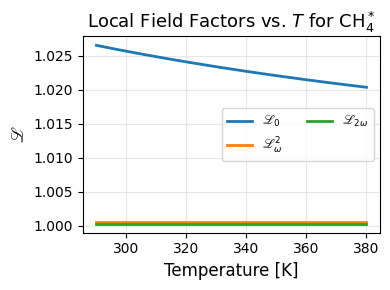

In [22]:
#==============================
# PLOTTING
#==============================

# Plot local field factors vs.Temperature for each gas
for gas in HARVEY_LEMMON_PARAMS.keys():

    if one_gas_only:
        if gas != gas_to_plot: continue # Plot for a single gas only

    plt.figure(figsize=(4, 3))

    L0, L_omega_squared, L_2omega = local_field_factors(T_K, p_Pa=p_Pa, gas=gas,
                                    lambda_fund=lambda_fund,
                                    lambda_SH=lambda_SH)
    label = GAS_LABELS.get(gas, gas)
    plt.plot(T_K, L0, lw=2, label=r"$\mathscr{L}_0$")
    plt.plot(T_K, L_omega_squared, lw=2, label=r"$\mathscr{L}_\omega^2$")
    plt.plot(T_K, L_2omega, lw=2, label=r"$\mathscr{L}_{2\omega}$")

    plt.xlabel("Temperature [K]", fontsize=12)
    plt.ylabel(r"$\mathscr{L}$", fontsize=12)
    plt.title(rf"Local Field Factors vs. $T$ for {label}", fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9, ncol=2)
    plt.tight_layout()
    plt.show()

### - Final Third-Order Susceptibility Modeling

In [23]:
#==============================
# Chi3 calculation
#==============================

def chi3(
    T_K,
    lambda_fund_um,
    lambda_SH_um,
    gas,
    p_Pa=1e5,
):
    
    # χ^(3)(T) in SI units [m^2 / V^2].

    # Molecular number density N(T) 
    N_T = molecular_density(T_K, p_Pa=p_Pa)  # [m^-3]

    # Hyperpolarizability Γ(T) = γ (nonpolar)
    gamma_val = gamma_SI(gas)  # [m^5 / V^2]

    # Local-field factors
    L0, L_omega_squared, L_2omega = local_field_factors(
        T_K, p_Pa=p_Pa, gas=gas, lambda_fund=lambda_fund_um, lambda_SH=lambda_SH_um
    )

    # Full χ^(3)(T) 
    chi3_T = 0.25 * N_T * L0 * L_omega_squared * L_2omega * gamma_val #[m^2 / V^2]

    return chi3_T

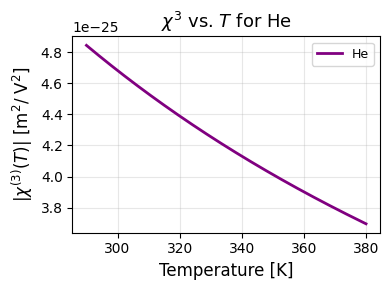

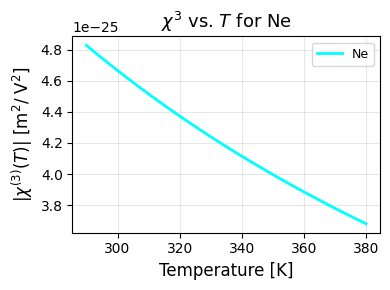

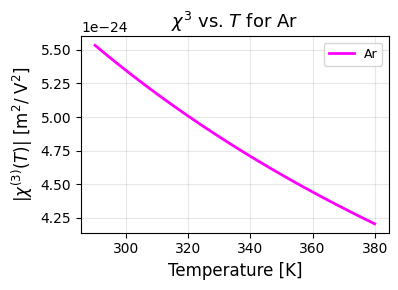

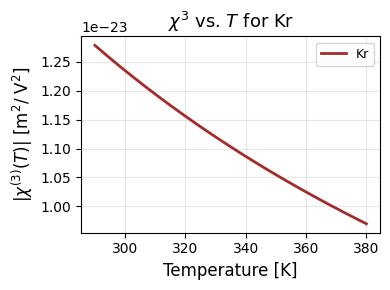

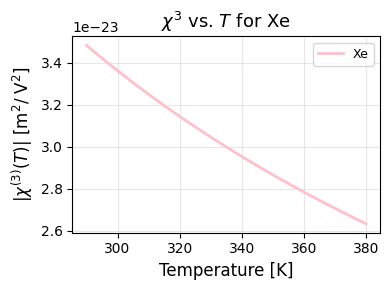

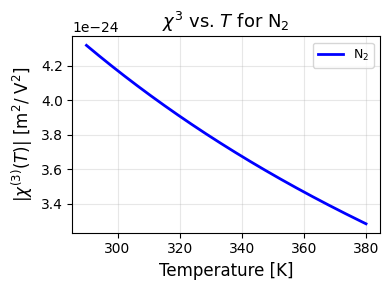

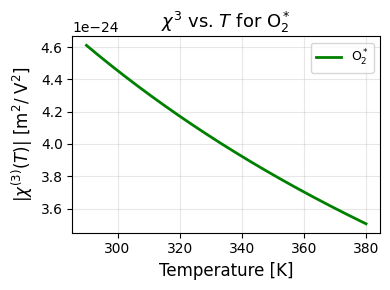

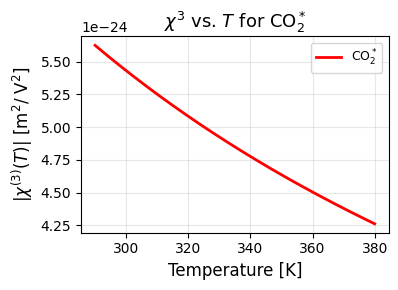

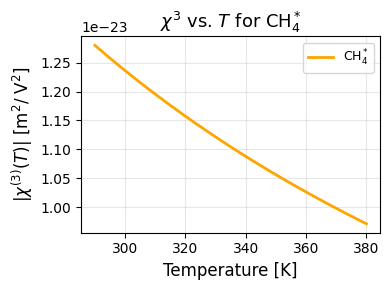

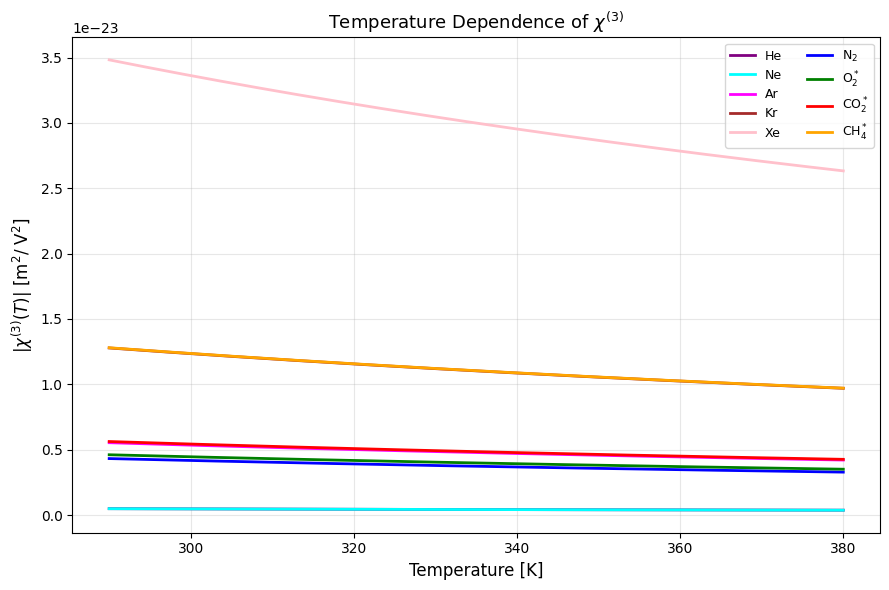

In [24]:
#==============================
# PLOTTING
#==============================

# Plotting χ^(3)(T) for each gas
if ploting:
    for gas in HARVEY_LEMMON_PARAMS.keys():
        if one_gas_only:
            
            if gas != gas_to_plot: continue # Plot for a single gas only

        plt.figure(figsize=(4, 3))

        chi3_T = chi3(T_K, lambda_fund, lambda_SH, gas=gas, p_Pa=p_Pa)
        label = GAS_LABELS.get(gas, gas)
        
        plt.plot(T_K, chi3_T, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

        plt.xlabel("Temperature [K]", fontsize=12)
        plt.ylabel(r"$|\chi^{(3)}(T)|$ [m$^2$/ V$^2$]", fontsize=12)
        plt.title(rf"$\chi^{(3)}$ vs. $T$ for {label}", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=9, ncol=2)
        plt.tight_layout()
        plt.show()


# Plotting χ^(3)(T) for all gases
plt.figure(figsize=(9, 6))
for gas in HARVEY_LEMMON_PARAMS.keys():

    chi3_T = chi3(T_K, lambda_fund, lambda_SH, gas=gas, p_Pa=p_Pa)
    label = GAS_LABELS.get(gas, gas)
    plt.plot(T_K, chi3_T, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"$|\chi^{(3)}(T)|$ [m$^2$/ V$^2$]", fontsize=12)
plt.title(r"Temperature Dependence of $\chi^{(3)}$", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

------------------------------------------------------------------

# <span style='color:red'>Final Calculation of Ccal</span>

------------------------------------------------------------------

In [25]:
def square_root_term(omega, n_omega, n_2omega):

    # Square root term sqrt( (9/2) ω^2 / (ε0 c^3 n_ω^2 n_2ω) )
    sqrt_term = np.sqrt(
        (9.0 / 2.0) * omega**2 / (epsilon_0 * c**3 * n_omega**2 * n_2omega)
    )
    return sqrt_term


def oscillating_term(delta_k_m, L_m, limit=False):
    
    # Oscillating factor 4 sin(Δk L / 2) / Δk.
    
    # Handle the limit Δk → 0 to avoid division by zero
    if limit:
        delta_k_m = np.asarray(delta_k_m, dtype=float)
        arg = delta_k_m * L_m / 2.0
        osc = np.empty_like(delta_k_m)

        mask = delta_k_m != 0
        osc[mask] = 4.0 * np.sin(arg[mask]) / delta_k_m[mask]
        osc[~mask] = 2.0 * L_m  # limit Δk→0: 4 sin(x)/Δk ~ 2L

        return osc
    
    # General case
    else:
        return 4.0 * np.sin(delta_k_m * L_m / 2.0) / delta_k_m

In [26]:
def ccal_T(
    T_K,
    lambda_fund_um,
    lambda_SH_um,
    gas,
    p_Pa=1e5,
    L_m=0.09,
):
    """
    Temperature-dependent calibration constant C_cal(T) for EFISH.
    C_cal(T) = sqrt( (9/2) * ω^2 / (ε0 c^3 n_ω^2 n_2ω) )
                * [4 sin(Δk L / 2)/Δk] * |χ^(3)(T)|
    """
    
    T_K = np.asarray(T_K, dtype=float)

    # --- Refractive indices at ω and 2ω ---
    n_omega  = refractive_index(lambda_fund_um, T_K, p_Pa=p_Pa, gas=gas)
    n_2omega = refractive_index(lambda_SH_um,   T_K, p_Pa=p_Pa, gas=gas)

    # --- Angular frequency ω ---
    omega = angular_frequency(lambda_fund_um)  # [rad/s]

    # --- Square-root prefactor ---
    sqrt_term = square_root_term(omega, n_omega, n_2omega)

    # --- Wavevector mismatch and oscillating term ---
    delta_k_m = wavevector_mismatch(lambda_fund_um, lambda_SH_um, T_K, p_Pa=1e5, gas=gas, to_m=True) # [rad/m]
    osc_term  = oscillating_term(delta_k_m, L_m, limit=False)

    # --- Third-order susceptibility χ^(3)(T) ---
    chi3_T = chi3(T_K, lambda_fund_um, lambda_SH_um, gas=gas, p_Pa=p_Pa)

    # --- Final C_cal(T) ---
    C_cal_T = sqrt_term * osc_term * np.abs(chi3_T)

    return C_cal_T

### Sqrt Term

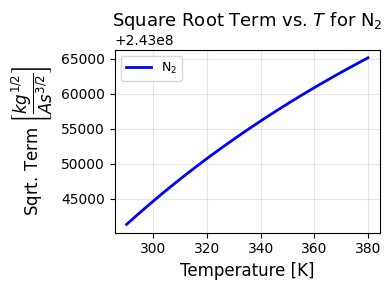

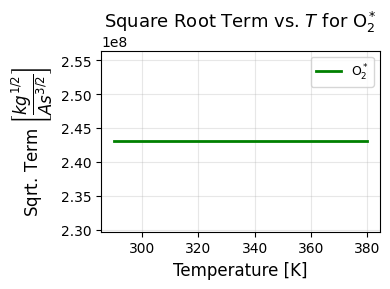

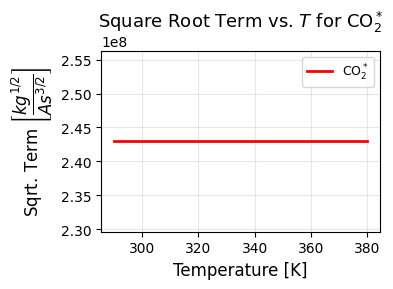

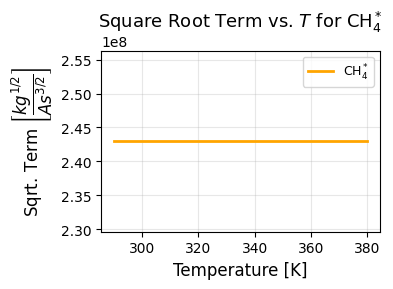

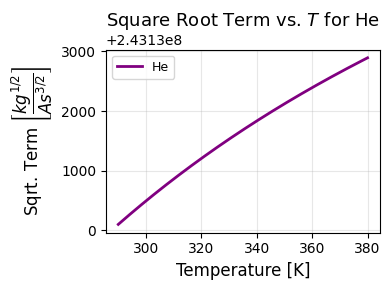

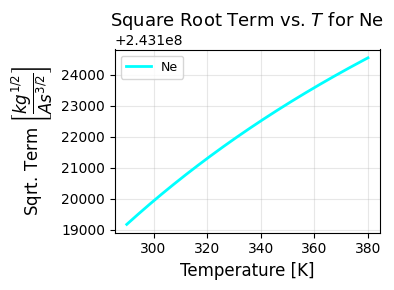

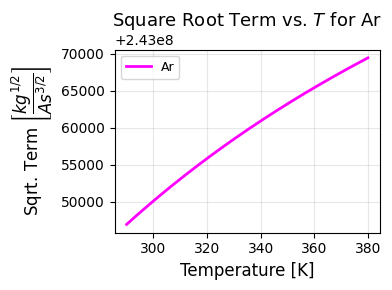

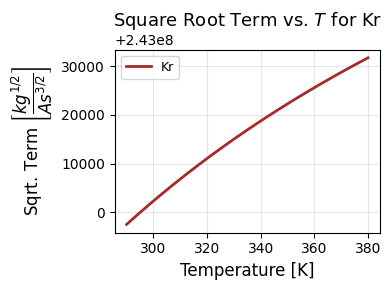

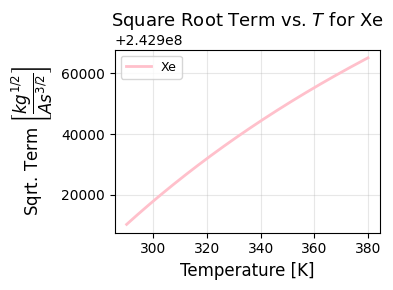

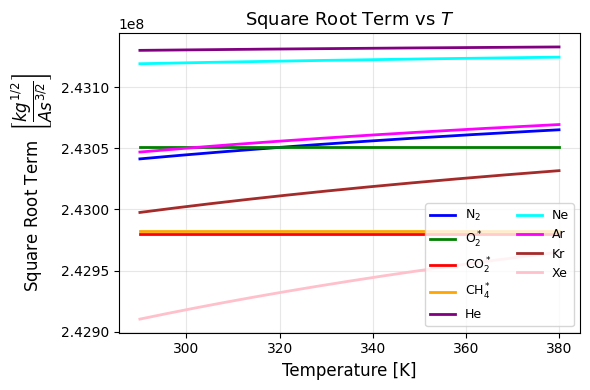

In [27]:
#==============================
# SQRT TERM PLOTTING
#==============================

# Plotting sqrt term vs.Temperature for each gas
if ploting:
    for gas in GAS_LABELS.keys():
        n_omega  = refractive_index(lambda_fund, T_K, p_Pa=p_Pa, gas=gas)
        n_2omega = refractive_index(lambda_SH,   T_K, p_Pa=p_Pa, gas=gas)
        omega = angular_frequency(lambda_fund)  

        if one_gas_only:
            
            if gas != gas_to_plot: continue # Plot for a single gas only

        plt.figure(figsize=(4, 3))

        label = GAS_LABELS.get(gas, gas)
        
        plt.plot(T_K, square_root_term(omega, n_omega, n_2omega), lw=2, label=label, color=GAS_COLORS.get(gas, gas))

        plt.xlabel("Temperature [K]", fontsize=12)
        plt.ylabel(r"Sqrt. Term $ \left[ \dfrac{kg^{1/2}}{A s^{3/2}} \right] $", fontsize=12)
        plt.title(rf"Square Root Term vs. $T$ for {label}", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=9, ncol=2)
        plt.tight_layout()
        plt.show()


# Plotting sqrt term for all gases
plt.figure(figsize=(6, 4))
for gas in GAS_LABELS.keys():
    n_omega  = refractive_index(lambda_fund, T_K, p_Pa=p_Pa, gas=gas)
    n_2omega = refractive_index(lambda_SH,   T_K, p_Pa=p_Pa, gas=gas)
    omega = angular_frequency(lambda_fund)

    label = GAS_LABELS.get(gas, gas)
    plt.plot(T_K, square_root_term(omega, n_omega, n_2omega), lw=2, label=label, color=GAS_COLORS.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"Square Root Term  $ \left[ \dfrac{kg^{1/2}}{A s^{3/2}} \right] $", fontsize=12)
plt.title(r"Square Root Term vs $T$", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

### Osc Term

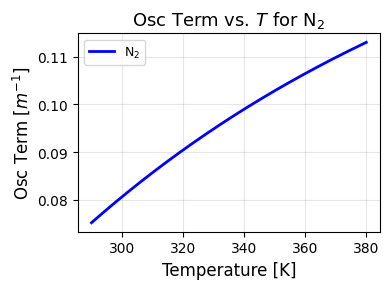

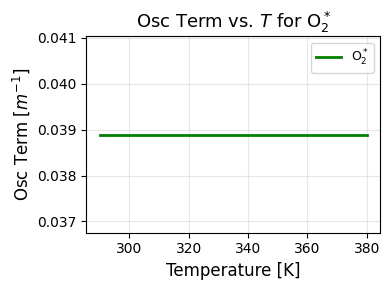

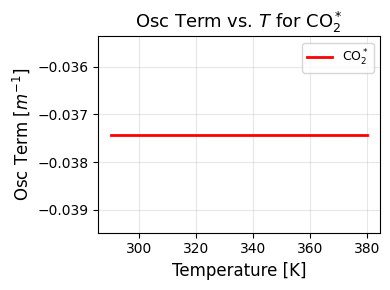

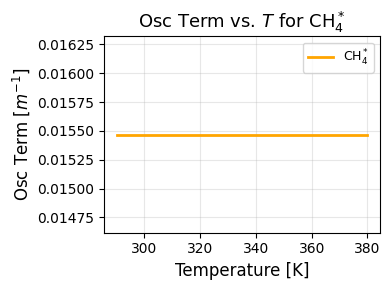

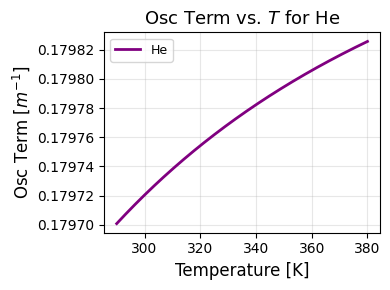

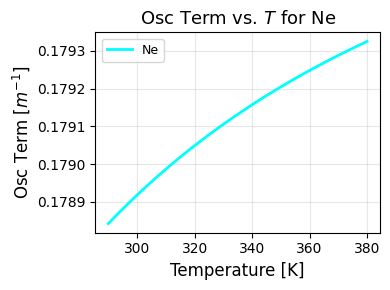

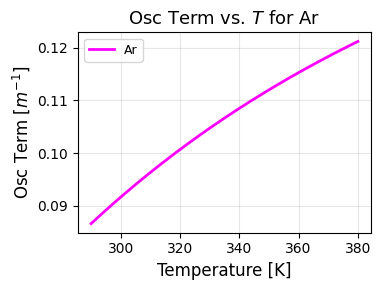

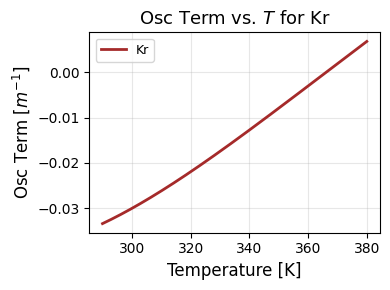

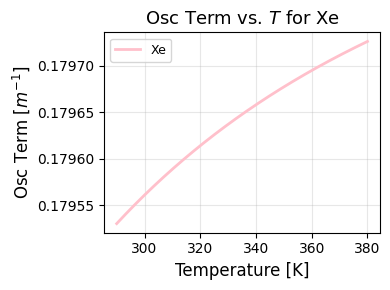

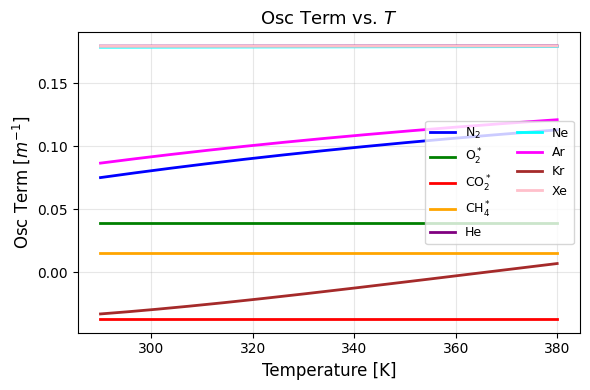

In [28]:
#==============================
# OSCILLATING TERM PLOTTING
#==============================

# Plotting Ccal for each gas
if ploting:
    for gas in GAS_LABELS.keys():
        delta_k_m = wavevector_mismatch(lambda_fund, lambda_SH, T_K, p_Pa=1e5, gas=gas, to_m=True) # [rad/m]
        osc_term  = oscillating_term(delta_k_m, L_m, limit=False)

        if one_gas_only:
            
            if gas != gas_to_plot: continue # Plot for a single gas only

        plt.figure(figsize=(4, 3))

        label = GAS_LABELS.get(gas, gas)
        
        plt.plot(T_K, osc_term, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

        plt.xlabel("Temperature [K]", fontsize=12)
        plt.ylabel(r"Osc Term [$m^{-1}$]", fontsize=12)
        plt.title(rf"Osc Term vs. $T$ for {label}", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=9, ncol=2)
        plt.tight_layout()
        plt.show()


# Plotting Ccal for all gases
plt.figure(figsize=(6, 4))
for gas in GAS_LABELS.keys():
    delta_k_m = wavevector_mismatch(lambda_fund, lambda_SH, T_K, p_Pa=1e5, gas=gas, to_m=True) # [rad/m]
    osc_term  = oscillating_term(delta_k_m, L_m, limit=False)

    label = GAS_LABELS.get(gas, gas)
    plt.plot(T_K, osc_term, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"Osc Term [$m^{-1}$]", fontsize=12)
plt.title(r"Osc Term vs. $T$", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

## <span style='color:red'>Final Plot of Ccal</span>

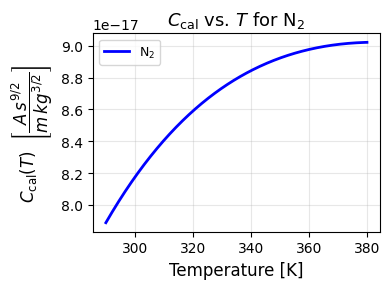

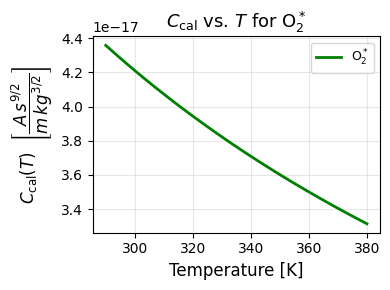

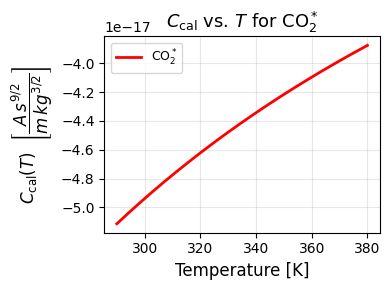

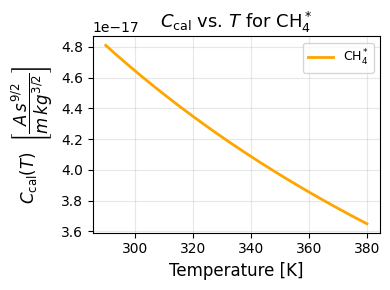

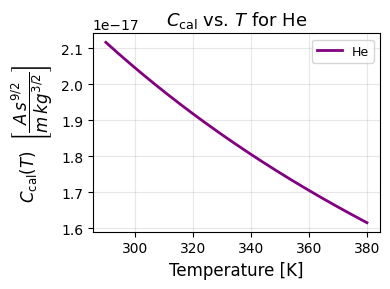

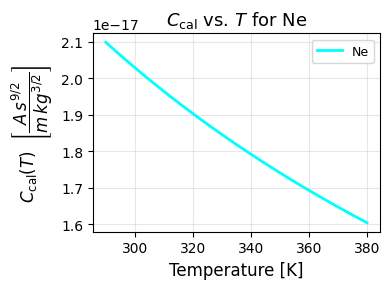

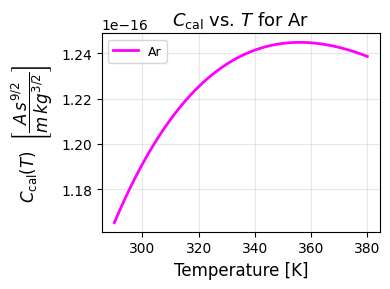

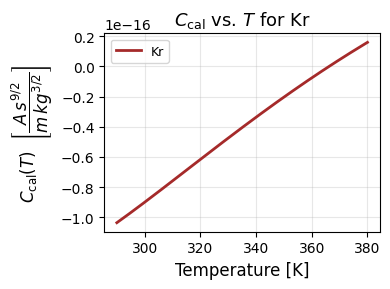

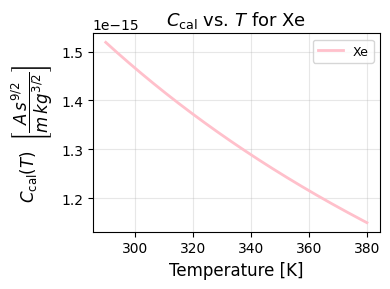

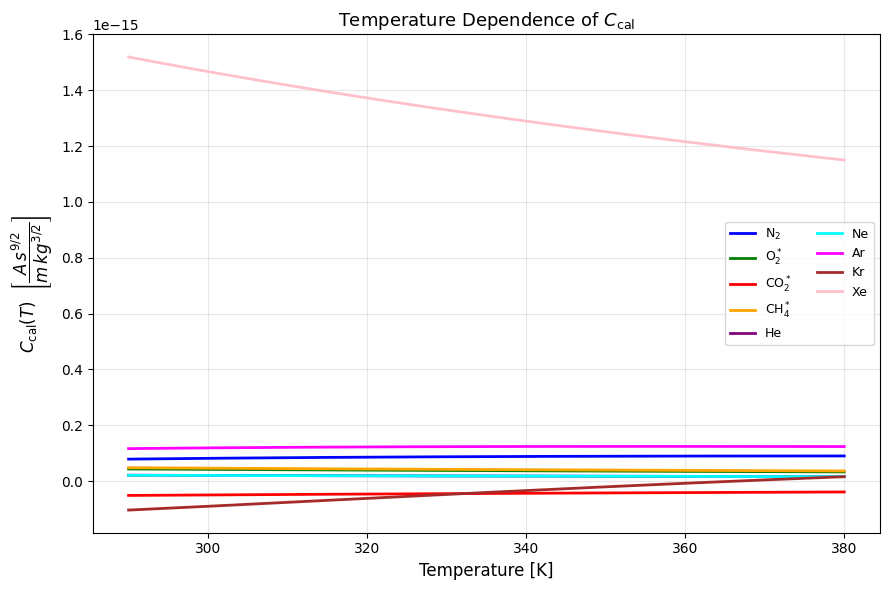

In [29]:
#==============================
# PLOTTING
#==============================

# Plotting Ccal for each gas
if ploting:
    for gas in GAS_LABELS.keys():
        if one_gas_only:
            
            if gas != gas_to_plot: continue # Plot for a single gas only

        plt.figure(figsize=(4, 3))

        ccal = ccal_T(T_K, lambda_fund, lambda_SH, gas, p_Pa=p_Pa, L_m=0.09)
        label = GAS_LABELS.get(gas, gas)
        
        plt.plot(T_K, ccal, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

        plt.xlabel("Temperature [K]", fontsize=12)
        plt.ylabel(r"$C_{\mathrm{cal}}(T)$  $\left[\dfrac{A\, s^{9/2}}{m\, kg^{3/2}}\right]$", fontsize=12)
        plt.title(rf"$C_{{\mathrm{{cal}}}}$ vs. $T$ for {label}", fontsize=13)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=9, ncol=2)
        plt.tight_layout()
        plt.show()


# Plotting Ccal for all gases
plt.figure(figsize=(9, 6))
for gas in GAS_LABELS.keys():

    ccal = ccal_T(T_K, lambda_fund, lambda_SH, gas, p_Pa=p_Pa, L_m=0.09)
    label = GAS_LABELS.get(gas, gas)
    plt.plot(T_K, ccal, lw=2, label=label, color=GAS_COLORS.get(gas, gas))

plt.xlabel("Temperature [K]", fontsize=12)
plt.ylabel(r"$C_{\mathrm{cal}}(T)$  $\left[\dfrac{A\, s^{9/2}}{m\, kg^{3/2}}\right]$", fontsize=12)
plt.title(r"Temperature Dependence of $C_{{\mathrm{{cal}}}}$", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

-------------